In [ ]:
!pip install keras

In [ ]:
!pip install tensorflow

In [ ]:
!pip install kaggle


Transfer Learning for Computer Vision Tutorial
==============================================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at `cs231n notes <https://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import time
import os
import gc
import copy
import pandas as pd
import cv2 as cv
import json, codecs
import requests
from bs4 import BeautifulSoup
import lxml
import os
import urllib
import sys
import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path
import os.path
import tensorflow as tf
import seaborn as sns
import cv2
import csv
import multiprocessing
import matplotlib.pyplot as plt

plt.ion()   # interactive mode

2023-04-27 02:04:54.572690: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [16]:
# Run this cell after uploading the json file
!mv kaggle.json ../.kaggle/
!chmod 600 ../.kaggle/kaggle.json

mv: cannot stat ‘kaggle.json’: No such file or directory


In [ ]:
# This will download and unzip our data takes 10+ minutes, make sure your computer doesnt go to sleep while its running
!kaggle competitions download -c iwildcam2022-fgvc9
!unzip iwildcam2022-fgvc9.zip

In [2]:
# Get json data to local variables
with codecs.open("/home/ec2-user/SageMaker/metadata/metadata/iwildcam2022_train_annotations.json", 'r',
                 encoding='utf-8', errors='ignore') as f:
    train_meta = json.load(f)

# with codecs.open("/home/ec2-user/SageMaker/metadata/metadata/iwildcam2022_test_information.json", 'r',
#                  encoding='utf-8', errors='ignore') as f:
#     test_meta = json.load(f)
    
# with codecs.open("/home/ec2-user/SageMaker/metadata/metadata/gps_locations.json", 'r',
#                  encoding='utf-8', errors='ignore') as f:
#     gps_meta = json.load(f)
    
# with codecs.open("/home/ec2-user/SageMaker/metadata/metadata/iwildcam2022_mdv4_detections.json", 'r',
#                  encoding='utf-8', errors='ignore') as f:
#     iwildc_meta = json.load(f)

(1196, 1812, 3)


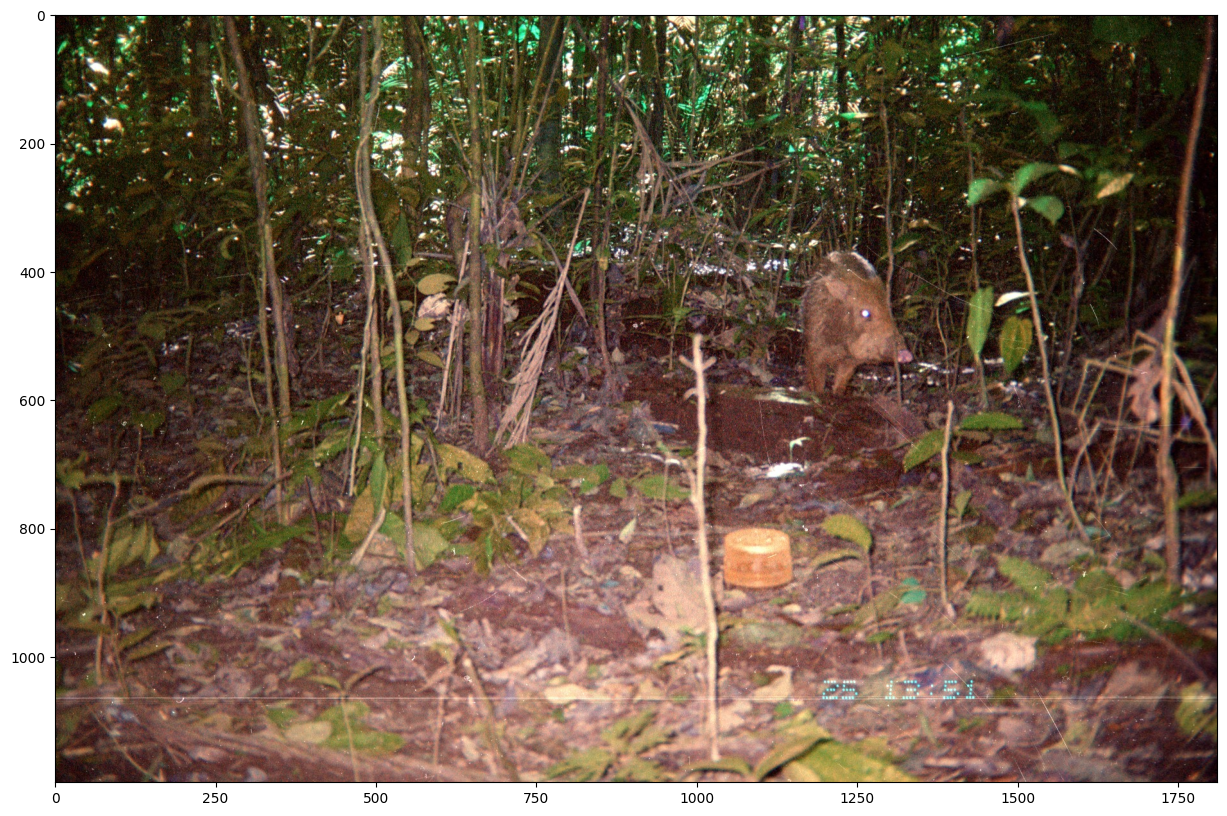

In [3]:
# View an image
img = cv.imread('/home/ec2-user/SageMaker/train/train/887cd0ec-21bc-11ea-a13a-137349068a90.jpg')
print(img.shape )
(1536, 2048, 3)
pumaid = "879d74d8-21bc-11ea-a13a-137349068a90"

plt.figure(figsize=(15,15))
plt.imshow(img)

Load Data
---------
Loading wildcam data and distinguishing between train and test data by label presence.


In [4]:
df = pd.DataFrame(train_meta['annotations'])
#train_df = df.iloc[:10001] #Take first 10,000 images at train set
train_df = df.sample(n=10000, random_state=42) #Take random images from df to remove sequences
#test_df = df.iloc[10001:13001] #Take next 3,000 sequence images as test set
df_rest = df.loc[~df.index.isin(train_df.index)]
test_df = df_rest.sample(n=3000, random_state=2) #Take test samples that arent in train
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

class_df = pd.DataFrame(train_meta['categories'])
label_to_index_map = {}
index_to_label_map = {}

for row in class_df.itertuples():
    label_to_index_map[row[1]] = row[0]
    index_to_label_map[row[0]] = row[1]
    
display(train_df)
display(test_df)

,id,image_id,category_id
0,9bcf2b2c-21bc-11ea-a13a-137349068a90,93f1df76-21bc-11ea-a13a-137349068a90,0
1,9dde3868-21bc-11ea-a13a-137349068a90,92a6d784-21bc-11ea-a13a-137349068a90,375
2,9ebc2c5e-21bc-11ea-a13a-137349068a90,955a837c-21bc-11ea-a13a-137349068a90,0
3,9df0e9e0-21bc-11ea-a13a-137349068a90,8ed2f9ee-21bc-11ea-a13a-137349068a90,110
4,9fc2a6f0-21bc-11ea-a13a-137349068a90,8fa308c8-21bc-11ea-a13a-137349068a90,567
...,...,...,...
9995,a266c922-21bc-11ea-a13a-137349068a90,882c3baa-21bc-11ea-a13a-137349068a90,372
9996,a3352056-21bc-11ea-a13a-137349068a90,94684d0a-21bc-11ea-a13a-137349068a90,10
9997,9dc218ea-21bc-11ea-a13a-137349068a90,8e6b9204-21bc-11ea-a13a-137349068a90,0
9998,a00286da-21bc-11ea-a13a-137349068a90,94235c72-21bc-11ea-a13a-137349068a90,91


,id,image_id,category_id
0,9b8e7118-21bc-11ea-a13a-137349068a90,8e658b3e-21bc-11ea-a13a-137349068a90,317
1,9b04f91a-21bc-11ea-a13a-137349068a90,93ea4004-21bc-11ea-a13a-137349068a90,380
2,a16bda1c-21bc-11ea-a13a-137349068a90,8883cc12-21bc-11ea-a13a-137349068a90,256
3,a0448fb2-21bc-11ea-a13a-137349068a90,8e0a94ae-21bc-11ea-a13a-137349068a90,96
4,a0802978-21bc-11ea-a13a-137349068a90,86e48a9a-21bc-11ea-a13a-137349068a90,0
...,...,...,...
2995,9ef26ef4-21bc-11ea-a13a-137349068a90,90cd13e2-21bc-11ea-a13a-137349068a90,0
2996,9be25648-21bc-11ea-a13a-137349068a90,8ba6da7e-21bc-11ea-a13a-137349068a90,371
2997,a213e70c-21bc-11ea-a13a-137349068a90,90c937e0-21bc-11ea-a13a-137349068a90,6
2998,a2c3a872-21bc-11ea-a13a-137349068a90,954ec28a-21bc-11ea-a13a-137349068a90,10


In [5]:
class DatasetIWILDCAM(Dataset):
    def __init__(self, df, path, transform=None):
        if 'category_id' in df.columns:
            self.labels = df.category_id
            self.image_ids = df.image_id
        else:
            self.image_ids = df.id
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.image_ids.index)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.path + "/" + self.image_ids[idx] + '.jpg'
        # Read the image from the file path
        image = Image.open(img_name)

        # Transform the image using self.transform
        if self.transform:
            image = self.transform(image)

        if hasattr(self, 'labels'):
            label = label_to_index_map[self.labels[idx]]
            sample = (image, label)
        else:
            sample = (image)

        return sample


In [6]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [ ]:
def annotation_map(df):
    dict = {}
    for row in 

In [7]:
print(train_df)
print(test_df)
# print(train_df.columns)
# print(test_df.columns)
# print(class_df.columns)
# print(class_df)
# print(len(class_df['id']))

                                         id  \
0      a292dd3c-21bc-11ea-a13a-137349068a90   
1      a0afcfc0-21bc-11ea-a13a-137349068a90   
2      a306e9c0-21bc-11ea-a13a-137349068a90   
3      9eed94c4-21bc-11ea-a13a-137349068a90   
4      a2a4dd7a-21bc-11ea-a13a-137349068a90   
...                                     ...   
9996   a1fcda26-21bc-11ea-a13a-137349068a90   
9997   9bf665e8-21bc-11ea-a13a-137349068a90   
9998   9f713248-21bc-11ea-a13a-137349068a90   
9999   9c1b7f7c-21bc-11ea-a13a-137349068a90   
10000  9dff8446-21bc-11ea-a13a-137349068a90   

                                   image_id  category_id  
0      96b00332-21bc-11ea-a13a-137349068a90           73  
1      879d74d8-21bc-11ea-a13a-137349068a90            4  
2      9017f7aa-21bc-11ea-a13a-137349068a90          227  
3      90d93c58-21bc-11ea-a13a-137349068a90          250  
4      887cd0ec-21bc-11ea-a13a-137349068a90            2  
...                                     ...          ...  
9996   956f313c-21bc-1

In [8]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(227),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        AddGaussianNoise(0., np.sqrt(0.1)) #Optionally add gaussian noise
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(227),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


train_dataset = DatasetIWILDCAM(df=train_df, path='/home/ec2-user/SageMaker/train/train/', transform=data_transforms['train'])
test_dataset = DatasetIWILDCAM(df=test_df, path='/home/ec2-user/SageMaker/train/train/', transform=data_transforms['test'])

image_datasets = {
    'train': train_dataset,
    'test': test_dataset
}

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)
}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
#class_names = class_df['id']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# # Get a batch of training data
# inputs, classes = next(iter(dataloaders['train']))
# #Get a batch of test data
# test_inputs = next(iter(dataloaders['test']))
# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)
# imshow(out, title=[classes])

# out2 = torchvision.utils.make_grid(test_inputs)
# imshow(out2)
# imshow(out, title=[class_names[x] for x in classes])

In [8]:
print(classes)

NameError: name 'classes' is not defined

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [10]:
epoch_map = {'train': {'loss_list': [], 'acc_list': []},
             'test': {'loss_list': [], 'acc_list': []}}


In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            epoch_map[phase]['loss_list'].append(epoch_loss)
            epoch_map[phase]['acc_list'].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
# def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
#     since = time.time()

#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

#     for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch, num_epochs - 1))
#         print('-' * 10)

#         model.train()  # Set model to training mode

#         running_loss = 0.0
#         running_corrects = 0

#         # Iterate over data.
#         for inputs, labels in dataloaders['train']:
#             inputs = inputs.to(device)
#             labels = labels.to(device) 

#             # zero the parameter gradients
#             optimizer.zero_grad()

#             # forward
#             # track history if only in train
#             with torch.set_grad_enabled(True):
#                 outputs = model(inputs)
#                 # print(outputs)
#                 # print(outputs.size())
#                 _, preds = torch.max(outputs, 1)
#                 # print(preds)
#                 # print(preds.size())
#                 # print(labels)
#                 # print(labels.size())
#                 loss = criterion(outputs, labels)
#                 #print(loss)
#                 # backward + optimize only if in training phase
#                 loss.backward()
#                 optimizer.step()

#             # statistics
#             running_loss += loss.item() * inputs.size(0)
#             running_corrects += torch.sum(preds == labels)

#         scheduler.step()

#         epoch_loss = running_loss / dataset_sizes['train']
#         epoch_acc = running_corrects.double() / dataset_sizes['train']
        
#          model.eval()  # Set model to eval mode

#         val_loss = 0.0
#         val_corrects = 0

#         # Iterate over data.
#         for inputs, labels in dataloaders['train']:
#             inputs = inputs.to(device)
#             labels = labels.to(device) 

#             # zero the parameter gradients
#             optimizer.zero_grad()

#             # forward
#             # track history if only in train
#             with torch.set_grad_enabled(False):
#                 outputs = model(inputs)
#                 _, preds = torch.max(outputs, 1)
#                 loss = criterion(outputs, labels)
 
#             # statistics
#             val_loss += loss.item() * inputs.size(0)
#             val_corrects += torch.sum(preds == labels)

#         scheduler.step()

#         epoch_loss = running_loss / dataset_sizes['train']
#         epoch_acc = running_corrects.double() / dataset_sizes['train']

#         print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

#         # deep copy the model
#         if epoch_acc > best_acc:
#             best_acc = epoch_acc
#             best_model_wts = copy.deepcopy(model.state_dict())

#         print()

#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(
#         time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

#     # load best model weights
#     model.load_state_dict(best_model_wts)
#     return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [12]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(preds[j]))
                out = torchvision.utils.make_grid(inputs.cpu().data[j])
                imshow(out)
                #imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [13]:
model_ft = models.resnet152(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
print(num_ftrs)
model_ft.fc = nn.Linear(num_ftrs, 205)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
#Add reg
#https://stackoverflow.com/questions/42704283/l1-l2-regularization-in-pytorch

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9, weight_decay = 0)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

2048


Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [20]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

In [15]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
train Loss: 2.7022 Acc: 0.4212
test Loss: 2.6997 Acc: 0.3833

Epoch 1/14
----------
train Loss: 1.9426 Acc: 0.5337
test Loss: 2.5974 Acc: 0.4197

Epoch 2/14
----------
train Loss: 1.6730 Acc: 0.5839
test Loss: 2.3824 Acc: 0.4683

Epoch 3/14
----------
train Loss: 1.5228 Acc: 0.6117
test Loss: 2.2421 Acc: 0.4903

Epoch 4/14
----------
train Loss: 1.4201 Acc: 0.6326
test Loss: 2.0945 Acc: 0.5113

Epoch 5/14
----------
train Loss: 1.3306 Acc: 0.6565
test Loss: 2.0542 Acc: 0.5223

Epoch 6/14
----------
train Loss: 1.2633 Acc: 0.6679
test Loss: 2.0748 Acc: 0.5217

Epoch 7/14
----------
train Loss: 1.1971 Acc: 0.6818
test Loss: 2.0374 Acc: 0.5257

Epoch 8/14
----------
train Loss: 1.1815 Acc: 0.6873
test Loss: 2.0769 Acc: 0.5193

Epoch 9/14
----------
train Loss: 1.1623 Acc: 0.6948
test Loss: 2.0765 Acc: 0.5210

Epoch 10/14
----------
train Loss: 1.1594 Acc: 0.6900
test Loss: 2.0462 Acc: 0.5233

Epoch 11/14
----------
train Loss: 1.1524 Acc: 0.6956
test Loss: 2.0159 Acc

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

58563853


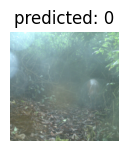

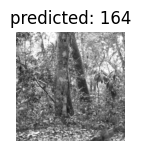

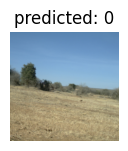

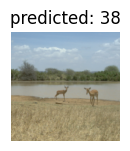

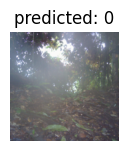

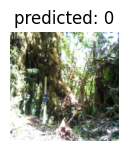

In [17]:
print(count_parameters(model_ft))
visualize_model(model_ft)

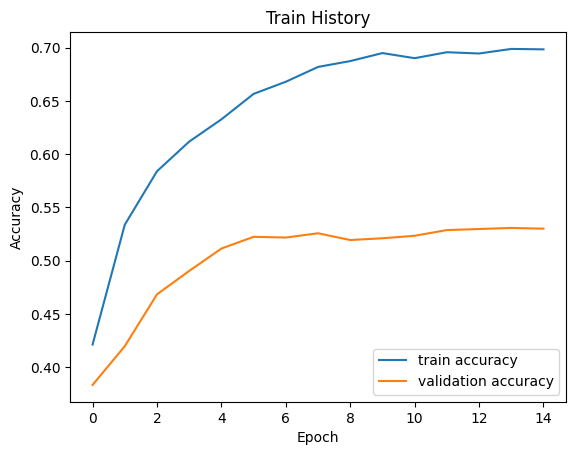

In [18]:
testAcc = []
trainAcc = []

for t in epoch_map['test']['acc_list'][:20]:
    testAcc.append(t.detach().cpu().numpy())
    
for ten in epoch_map['train']['acc_list'][:20]:
    trainAcc.append(ten.detach().cpu().numpy())  
    

plt.plot(trainAcc)
plt.plot(testAcc)
plt.title('Train History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train accuracy','validation accuracy'],loc='lower right')
fig1 = plt.gcf()
plt.show()
fig1.savefig('Resnet152_Run8_GaussianNoise_accuracies.png')

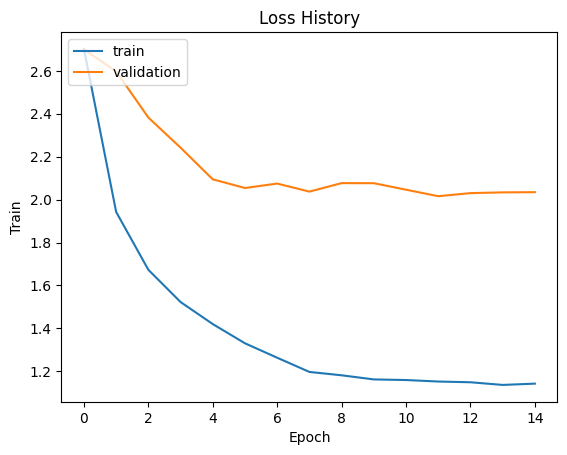

In [19]:
plt.plot(epoch_map['train']['loss_list'][:20])
plt.plot(epoch_map['test']['loss_list'][:20])
plt.title('Loss History')
plt.ylabel('Train')
plt.xlabel('Epoch')
plt.legend(['train','validation'],loc='upper left')
fig2 = plt.gcf()
plt.show()
fig2.savefig('Resnet152_Run8_GaussianNoise_loss.png')

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [19]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7076 Acc: 0.5984
val Loss: 0.3459 Acc: 0.8497

Epoch 1/24
----------
train Loss: 0.5415 Acc: 0.7295
val Loss: 0.4809 Acc: 0.7778

Epoch 2/24
----------
train Loss: 0.4428 Acc: 0.7910
val Loss: 0.4695 Acc: 0.8039

Epoch 3/24
----------
train Loss: 0.3768 Acc: 0.8484
val Loss: 0.1479 Acc: 0.9542

Epoch 4/24
----------
train Loss: 0.3394 Acc: 0.8566
val Loss: 0.1759 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.3995 Acc: 0.8197
val Loss: 0.1779 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.3845 Acc: 0.8320
val Loss: 0.3654 Acc: 0.8562

Epoch 7/24
----------
train Loss: 0.3378 Acc: 0.8443
val Loss: 0.1894 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3292 Acc: 0.8525
val Loss: 0.1722 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3394 Acc: 0.8320
val Loss: 0.1760 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3995 Acc: 0.7746
val Loss: 0.1791 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3403 Acc: 0.8484
val Loss: 0.2094 Acc: 0.9281

Ep

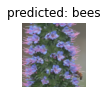

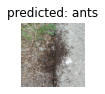

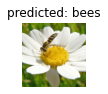

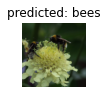

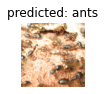

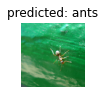

In [20]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Further Learning
-----------------

If you would like to learn more about the applications of transfer learning,
checkout our `Quantized Transfer Learning for Computer Vision Tutorial <https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html>`_.



